In [37]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)  
import warnings
#warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans


In [209]:
raw_full_join = pd.read_csv("full_join.csv")

In [3]:
full_join = raw_full_join.copy()
full_join = full_join.rename(columns={
'COMPAGNIE AERIENNE':'COMPAGNIE_CODE',
})

In [ ]:
# def _encode_dates(X):
#     X_encoded = X.copy()
#     X_encoded.loc[:, 'DATE'] = pd.to_datetime(X_encoded['DATE'], format="%d/%m/%Y", errors="coerce")
#     X_encoded.loc[:, 'year'] = X_encoded['DATE'].dt.year
#     X_encoded.loc[:, 'month'] = X_encoded['DATE'].dt.month
#     X_encoded.loc[:, 'day'] = X_encoded['DATE'].dt.day
#     X_encoded.loc[:, 'weekday'] = X_encoded['DATE'].dt.weekday
#     X_encoded.loc[:, 'week'] = X_encoded['DATE'].dt.week
#     return X_encoded.drop(columns=["DATE"])

# #date_encoder = FunctionTransformer(_encode_dates)
# #date_encoder.fit_transform(vols).head()
# full_join = _encode_dates(full_join)
# full_join.head()

In [389]:
%%time
def delay_byTime(min_delay, first_ten, minutes_after_ten):
    if min_delay <= 0 :
        return 0
    elif min_delay <= 10 : 
        return first_ten
    else :
        return first_ten + (min_delay - 10)*minutes_after_ten
    
full_join['PRIX_RETARD_DEPART'] = full_join.apply(lambda row : delay_byTime(row['TEMPS_RETARD_DEPART'], row['DEPART_PRIX_RETARD_10'], row['DEPART_PRIX_RETARD_APRES']), axis=1)
full_join['PRIX_RETARD_ARRIVEE'] = full_join.apply(lambda row : delay_byTime(row['TEMPS_RETARD_ARRIVEE'], row['ARRIVEE_PRIX_RETARD_10'], row['ARRIVEE_PRIX_RETARD_APRES']), axis=1)
# celui ci n'a aussi sens ! 
# Car prix retard moyen du vol ! 
#full_join['PRIX_RETARD_MOYEN'] = (full_join['PRIX_RETARD_DEPART'] + full_join['PRIX_RETARD_ARRIVEE']) / 2

Wall time: 3min 30s


In [391]:
print(full_join.shape)
full_join.head(1) #(3000000, 47)

(3000000, 49)


,IDENTIFIANT,VOL,CODE_AVION,AEROPORT_DEPART,AEROPORT_ARRIVEE,HEURE_DEPART_PROGRAMME,HEURE_DEPART,TEMPS_RETARD_DEPART,TEMPS_DEPLACEMENT_DECOLLAGE,HEURE_DECOLLAGE,TEMPS_PROGRAMME,TEMPS_PASSE,TEMPS_VOL,DISTANCE,HEURE_ATTERRISSAGE,TEMPS_DEPLACEMENT_ATTERRISSAGE,HEURE_ARRIVEE_PROGRAMMEE,HEURE_ARRIVEE,TEMPS_RETARD_ARRIVEE,DETOURNEMENT,ANNULATION,RAISON_ANNULATION,RETARD_SYSTEM,RETARD_SECURITE,RETARD_COMPAGNIE,RETARD_AVION,RETARD_METEO,DATE,NIVEAU_SECURITE,COMPAGNIE_CODE,COMPAGNIE,DEPART_NOM,DEPART_LIEU,DEPART_PAYS,DEPART_LONGITUDE,DEPART_LATITUDE,DEPART_HAUTEUR,DEPART_PRIX_RETARD_10,DEPART_PRIX_RETARD_APRES,ARRIVEE_NOM,ARRIVEE_LIEU,ARRIVEE_PAYS,ARRIVEE_LONGITUDE,ARRIVEE_LATITUDE,ARRIVEE_HAUTEUR,ARRIVEE_PRIX_RETARD_10,ARRIVEE_PRIX_RETARD_APRES,PRIX_RETARD_DEPART,PRIX_RETARD_ARRIVEE
0,651373,2317,28fa5df4d7,TIA,DSS,1410,1411.0,1.0,20.0,1431.0,229.0,227.0,197.0,1749,2048.0,10.0,2059,2058.0,-1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,10/4/2016,10,NVPPA,Ne Va Pas Partout Airlines,Tirana International Airport Mother Teresa,Tirana,AL,19.7206,41.4147,126.0,4582,586,Blaise Diagne International Airport,Dakar,SN,-17.073333,14.67,290.0,5499,120,4582.0,0.0


## Clustering sur les COMPAGNIE

In [296]:
full_join.COMPAGNIE.nunique()

13

In [315]:
full_join.groupby(['COMPAGNIE']).size()

COMPAGNIE
Air Penguin                      50335
Air Piloter Sans Les Mains       76986
Always A Problem Flights         59407
Bel Air                         194944
Better Take A Train Airlines     40587
Corporate Overlord Airways      466772
Fliying Is Possible Inc.        113559
IE 6.0 Flights                  378718
Morally Ambiguious Fligthts     385834
Ne Va Pas Partout Airlines      575679
Neverland Airlines              143045
Overpriced Air                  176341
Try Hard Airlines               337793
dtype: int64

In [381]:
compagnies = full_join[[
    'COMPAGNIE_CODE','COMPAGNIE',

    'TEMPS_RETARD_DEPART', 'TEMPS_DEPLACEMENT_DECOLLAGE', 
    'DEPART_PRIX_RETARD_10', 'DEPART_PRIX_RETARD_APRES',
    'PRIX_RETARD_DEPART', 
    
    'TEMPS_RETARD_ARRIVEE', 'TEMPS_DEPLACEMENT_ATTERRISSAGE', 
    'ARRIVEE_PRIX_RETARD_10','ARRIVEE_PRIX_RETARD_APRES',
    'PRIX_RETARD_ARRIVEE']]
print(compagnies.COMPAGNIE.nunique())

compagnies = compagnies.groupby(['COMPAGNIE']).mean()

compagnies['nb_vols'] = full_join.groupby(['COMPAGNIE']).size()
nb_vols_total = compagnies['nb_vols'].sum()
print("nb_vols_total : ",nb_vols_total)

compagnies['TEMPS_RETARD'] = compagnies['TEMPS_RETARD_DEPART'] + compagnies['TEMPS_RETARD_ARRIVEE']
compagnies['TEMPS_RETARD_eff'] = compagnies['TEMPS_RETARD'] * compagnies['nb_vols'] / nb_vols_total

compagnies['PRIX_RETARD'] =  compagnies['PRIX_RETARD_DEPART'] + compagnies['PRIX_RETARD_ARRIVEE']
compagnies['PRIX_RETARD_eff'] = compagnies['PRIX_RETARD'] * compagnies['nb_vols'] / nb_vols_total

print(compagnies.shape)
compagnies = compagnies.reset_index()
compagnies.head()


13
nb_vols_total :  3000000
(13, 15)


,COMPAGNIE,TEMPS_RETARD_DEPART,TEMPS_DEPLACEMENT_DECOLLAGE,DEPART_PRIX_RETARD_10,DEPART_PRIX_RETARD_APRES,PRIX_RETARD_DEPART,TEMPS_RETARD_ARRIVEE,TEMPS_DEPLACEMENT_ATTERRISSAGE,ARRIVEE_PRIX_RETARD_10,ARRIVEE_PRIX_RETARD_APRES,PRIX_RETARD_ARRIVEE,nb_vols,TEMPS_RETARD,TEMPS_RETARD_eff,PRIX_RETARD,PRIX_RETARD_eff
0,Air Penguin,0.589122,10.955118,7073.937658,315.918049,2862.643393,2.241709,6.844844,7077.168134,316.827476,3906.168148,50335,2.830831,0.047497,6768.811541,113.569376
1,Air Piloter Sans Les Mains,16.581153,14.671561,5122.303990,390.494531,8151.414405,15.145456,9.545127,5127.200244,390.272946,8772.870829,76986,31.726609,0.814168,16924.285234,434.311008
2,Always A Problem Flights,14.440415,15.790460,5832.359419,533.740738,9702.782164,13.961853,9.140495,5831.150420,533.748599,11161.717343,59407,28.402268,0.562431,20864.499507,413.165774
3,Bel Air,10.755019,16.612506,6134.765481,518.204725,7902.736970,7.406214,9.150463,6140.220509,517.098023,8627.873113,194944,18.161233,1.180141,16530.610083,1074.181084
4,Better Take A Train Airlines,9.215136,14.833354,4059.604011,512.973292,6087.042103,5.011111,8.168047,4057.436544,513.959347,6491.806099,40587,14.226247,0.192467,12578.848201,170.179237


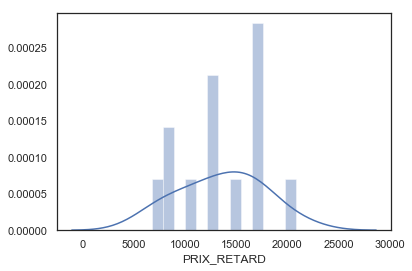

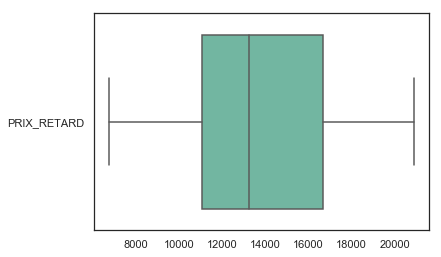

count       13.000000
mean     13548.245015
std       4106.850169
min       6768.811541
25%      11048.759881
50%      13222.975977
75%      16656.756754
max      20864.499507
Name: PRIX_RETARD, dtype: float64

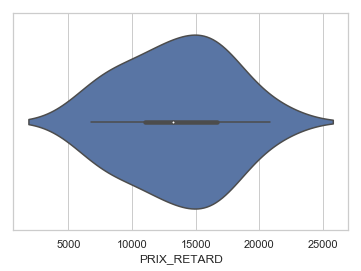

In [436]:
sns.set_style("white")
sns.distplot(compagnies['PRIX_RETARD'], bins=13)
plt.show()
#compagnies['PRIX_RETARD'].describe()
sns.boxplot(data=compagnies[['PRIX_RETARD']], orient="h", palette="Set2")
plt.show()
sns.set(style="whitegrid")
ax = sns.violinplot(x=compagnies['PRIX_RETARD'])
compagnies['PRIX_RETARD'].describe()


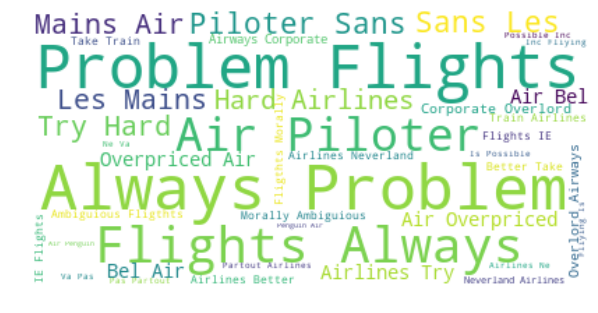

In [384]:
# Les aéroports qui paient le plus leurs retard (Décollage, attérissage confondu)
raw_text = compagnies[['COMPAGNIE', 'PRIX_RETARD']].groupby('COMPAGNIE').mean()['PRIX_RETARD'].sort_values(ascending=False).reset_index().apply(lambda row : (str(row.COMPAGNIE)+' ') * int(row.PRIX_RETARD), axis=1)
text = " ".join(code for code in raw_text)
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white").generate(text)
# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

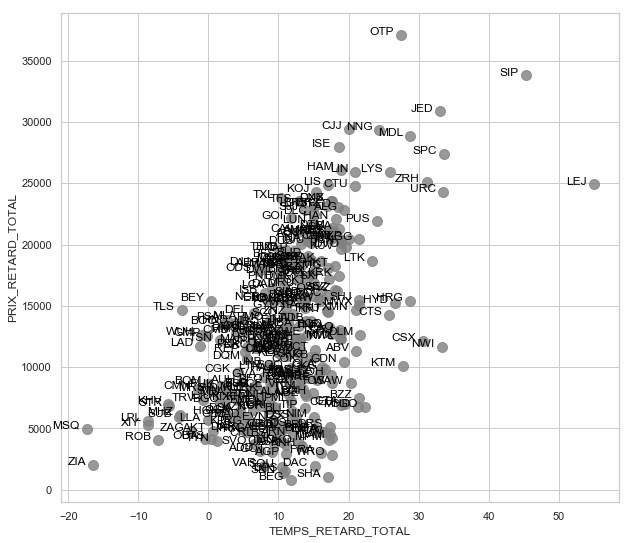

In [515]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,9))

p1=sns.regplot(data=aeroport_full, x="TEMPS_RETARD_TOTAL", y="PRIX_RETARD_TOTAL", fit_reg=False, marker="o", color="grey", scatter_kws={'s':100})

# add annotations one by one with a loop
for line in range(0,aeroport_full.shape[0]):
    p1.text(aeroport_full.TEMPS_RETARD_TOTAL[line]-1, aeroport_full.PRIX_RETARD_TOTAL[line], aeroport_full.AEROPORT[line], horizontalalignment='right', size='medium', color='black')
plt.show()


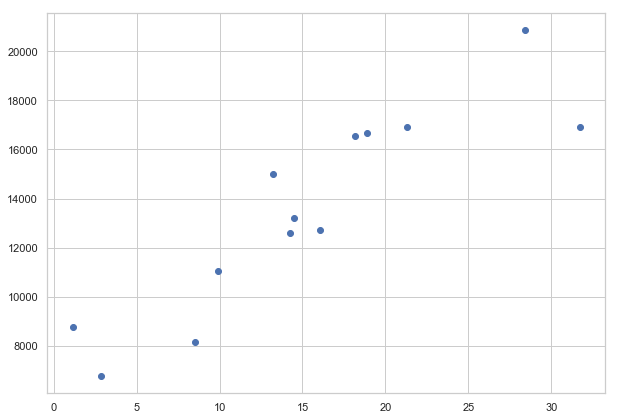

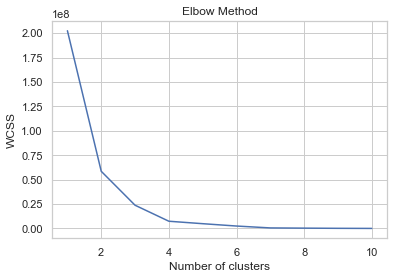

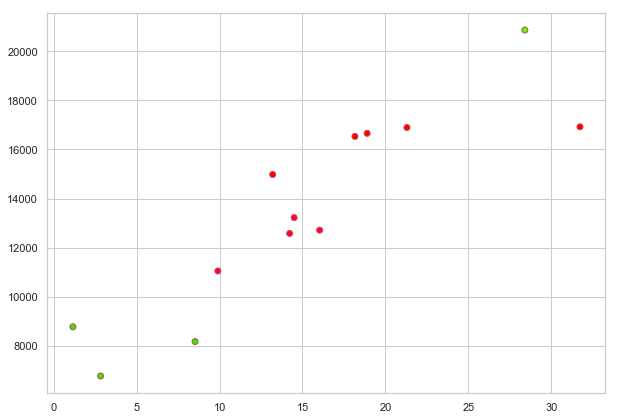

In [483]:
plt.figure(figsize=(10,7))
X = compagnies[['TEMPS_RETARD','PRIX_RETARD']].values
plt.scatter(X[:,0], X[:,1])
#plt.scatter(X[:,0], X[:,2],c="DarkGreen")
plt.show()
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
compagnies['cluster'] = pred_y
plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1],c=pred_y, cmap='prism', edgecolors='r')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='red')
plt.show()

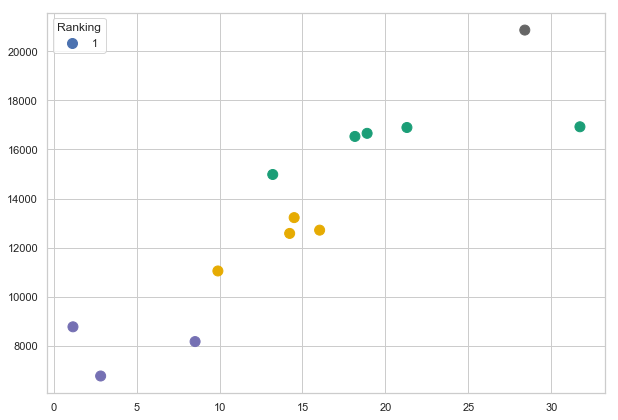

In [504]:
plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1],c=pred_y, cmap='Dark2',s=100)
plt.legend(list(compagnies['cluster'].unique()),
                    loc="upper left", title="Ranking")
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='red')
plt.show()


         TEMPS_RETARD   PRIX_RETARD
cluster                            
1            4.172585   7904.558312
2           13.663947  12390.610250
0           20.656991  16397.313951
3           28.402268  20864.499507


,cluster,COMPAGNIE
0,1,Air Penguin
1,0,Air Piloter Sans Les Mains
2,3,Always A Problem Flights
3,0,Bel Air
4,2,Better Take A Train Airlines
5,0,Corporate Overlord Airways
6,1,Fliying Is Possible Inc.
7,2,IE 6.0 Flights
8,2,Morally Ambiguious Fligthts
9,1,Ne Va Pas Partout Airlines


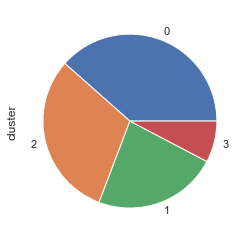

In [505]:
compagnies['cluster'].value_counts().plot.pie()
print(compagnies[['TEMPS_RETARD','PRIX_RETARD', 'cluster']].groupby('cluster').mean().sort_values(by="TEMPS_RETARD"))
compagnies.reset_index()[['cluster', 'COMPAGNIE']]

## Clustering sur les AEROPORTS 

In [356]:
depart_full_join = full_join[[
    'AEROPORT_DEPART',
    'DEPART_NOM',
    'HEURE_DEPART_PROGRAMME', 
    'DEPART_PAYS',
#     'DISTANCE',
    'TEMPS_RETARD_DEPART', 'TEMPS_DEPLACEMENT_DECOLLAGE', 
    'DEPART_PRIX_RETARD_10', 'DEPART_PRIX_RETARD_APRES',
    'PRIX_RETARD_DEPART', 
]].rename(columns={'AEROPORT_DEPART':'AEROPORT'})
depart_full_join = depart_full_join.groupby(['AEROPORT', 'DEPART_PAYS', 'DEPART_NOM']).mean().reset_index()
#depart_full_join.sort_values(by="PRIX_RETARD_DEPART",ascending=False).head(10)
print(depart_full_join.shape)
depart_full_join[depart_full_join['AEROPORT']=="AAL"][['DEPART_PAYS']]

(318, 9)


,DEPART_PAYS
0,DK


In [357]:
arrivee_full_join = full_join[[
    'AEROPORT_ARRIVEE',
    'HEURE_ARRIVEE_PROGRAMMEE', 
    #'ARRIVEE_PAYS',
    #'DISTANCE',
    'TEMPS_RETARD_ARRIVEE', 'TEMPS_DEPLACEMENT_ATTERRISSAGE', 
    'ARRIVEE_PRIX_RETARD_10','ARRIVEE_PRIX_RETARD_APRES',
    'PRIX_RETARD_ARRIVEE', 
]].rename(columns={'AEROPORT_ARRIVEE':'AEROPORT'})
arrivee_full_join = arrivee_full_join.groupby(['AEROPORT']).mean().reset_index()
#arrivee_full_join.sort_values(by="PRIX_RETARD_ARRIVEE",ascending=False).head(10)
print(arrivee_full_join.shape)
#arrivee_full_join[arrivee_full_join['AEROPORT']=="AAL"][['ARRIVEE_PAYS']]

(318, 7)


In [358]:
aeroport_full = depart_full_join.merge(arrivee_full_join)
aeroport_full = aeroport_full.drop(columns=['DEPART_PRIX_RETARD_10','DEPART_PRIX_RETARD_APRES'])
aeroport_full = aeroport_full.rename(
    columns={'ARRIVEE_PRIX_RETARD_10':'PRIX_RETARD_10', 
             'ARRIVEE_PRIX_RETARD_APRES':'PRIX_RETARD_APRES',
            'DEPART_PAYS':'PAYS'})
print(aeroport_full.shape)
aeroport_full['TEMPS_RETARD_TOTAL'] = aeroport_full['TEMPS_RETARD_DEPART'] + aeroport_full['TEMPS_RETARD_ARRIVEE']
aeroport_full['PRIX_RETARD_TOTAL'] = aeroport_full['PRIX_RETARD_DEPART'] + aeroport_full['PRIX_RETARD_ARRIVEE']
aeroport_full.head()

(318, 13)


,AEROPORT,PAYS,DEPART_NOM,HEURE_DEPART_PROGRAMME,TEMPS_RETARD_DEPART,TEMPS_DEPLACEMENT_DECOLLAGE,PRIX_RETARD_DEPART,HEURE_ARRIVEE_PROGRAMMEE,TEMPS_RETARD_ARRIVEE,TEMPS_DEPLACEMENT_ATTERRISSAGE,PRIX_RETARD_10,PRIX_RETARD_APRES,PRIX_RETARD_ARRIVEE,TEMPS_RETARD_TOTAL,PRIX_RETARD_TOTAL
0,AAL,DK,Aalborg Airport,1379.681418,7.189322,17.793955,5166.415919,1432.686522,3.074024,5.723256,8346.0,353.0,5885.003875,10.263346,11051.419794
1,AAP,ID,Aji Pangeran Tumenggung Pranoto International ...,1095.469636,7.395950,17.948951,5311.305866,1724.780339,4.988079,5.644008,9245.0,318.0,6479.122020,12.384028,11790.427886
2,ABV,NG,Nnamdi Azikiwe International Airport,1144.856947,11.500399,13.046772,5562.555911,1583.765920,9.498813,5.089779,6338.0,272.0,5741.827136,20.999213,11304.383047
3,ACC,GH,Kotoka International Airport,419.315094,3.550669,12.273423,8237.179732,285.523132,10.603604,4.365766,2880.0,955.0,12449.990991,14.154273,20687.170723
4,ADB,TR,Adnan Menderes International Airport,1092.162313,7.514395,16.398077,6878.211132,1920.741245,7.080483,4.771084,2955.0,603.0,6888.513078,14.594878,13766.724211


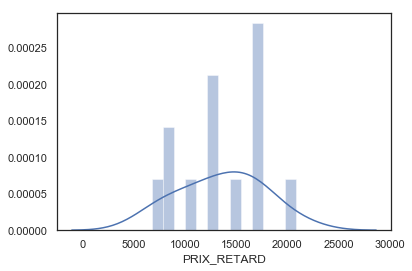

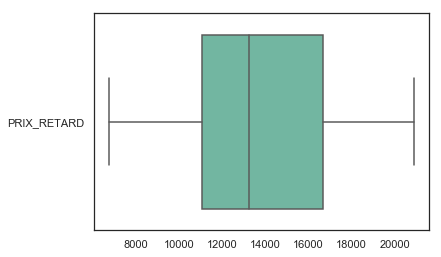

count       13.000000
mean     13548.245015
std       4106.850169
min       6768.811541
25%      11048.759881
50%      13222.975977
75%      16656.756754
max      20864.499507
Name: PRIX_RETARD, dtype: float64

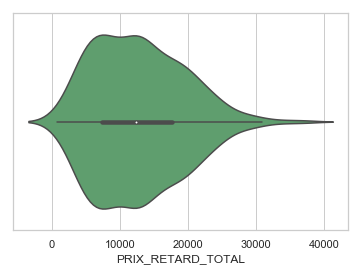

In [508]:

sns.set_style("white")
sns.distplot(compagnies['PRIX_RETARD'], bins=13)
plt.show()
#compagnies['PRIX_RETARD'].describe()
sns.boxplot(data=compagnies[['PRIX_RETARD']], orient="h", palette="Set2")
plt.show()
sns.set(style="whitegrid")
ax = sns.violinplot(x=aeroport_full['PRIX_RETARD_TOTAL'],color='g')
compagnies['PRIX_RETARD'].describe()


### Cluster par retard/prix 

In [360]:
aeroport_full.head(1)

,AEROPORT,PAYS,DEPART_NOM,HEURE_DEPART_PROGRAMME,TEMPS_RETARD_DEPART,TEMPS_DEPLACEMENT_DECOLLAGE,PRIX_RETARD_DEPART,HEURE_ARRIVEE_PROGRAMMEE,TEMPS_RETARD_ARRIVEE,TEMPS_DEPLACEMENT_ATTERRISSAGE,PRIX_RETARD_10,PRIX_RETARD_APRES,PRIX_RETARD_ARRIVEE,TEMPS_RETARD_TOTAL,PRIX_RETARD_TOTAL
0,AAL,DK,Aalborg Airport,1379.681418,7.189322,17.793955,5166.415919,1432.686522,3.074024,5.723256,8346.0,353.0,5885.003875,10.263346,11051.419794


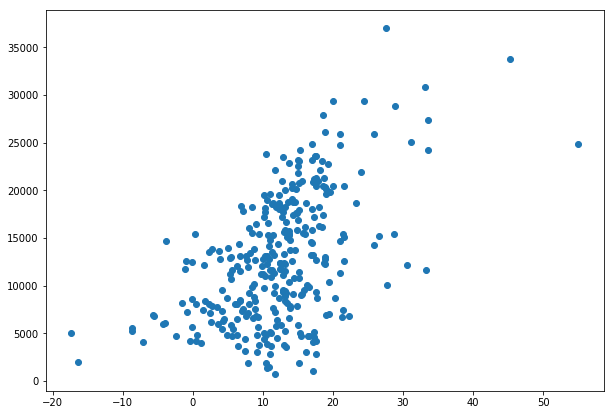

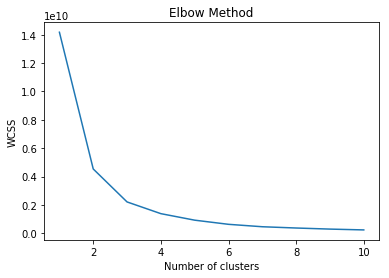

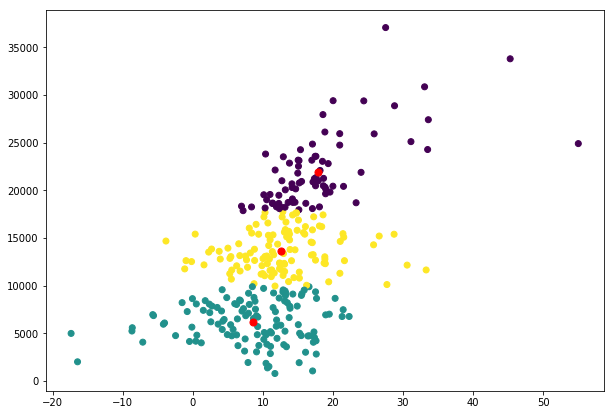

In [361]:
plt.figure(figsize=(10,7))
X = aeroport_full.set_index('AEROPORT')[['TEMPS_RETARD_TOTAL','PRIX_RETARD_TOTAL']].values
plt.scatter(X[:,0], X[:,1])
#plt.scatter(X[:,0], X[:,2],c="DarkGreen")
plt.show()
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
aeroport_full['cluster'] = pred_y
plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1],c=pred_y)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='red')
plt.show()

,TEMPS_RETARD_TOTAL,PRIX_RETARD_TOTAL
cluster,,
1,8.599708,6232.989854
2,12.548813,13631.911300
0,17.916508,21979.441044


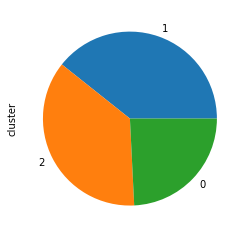

In [362]:
aeroport_full['cluster'].value_counts().plot.pie()
aeroport_full[['TEMPS_RETARD_TOTAL','PRIX_RETARD_TOTAL', 'cluster']].groupby('cluster').mean().sort_values(by="TEMPS_RETARD_TOTAL")

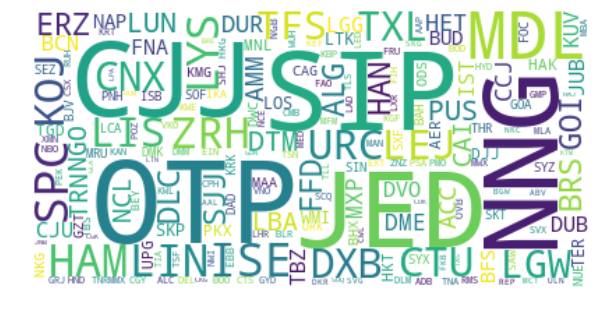

In [379]:
# Les aéroports qui paient le plus leurs retard (Décollage, attérissage confondu)
raw_text = aeroport_full[['AEROPORT', 'PRIX_RETARD_TOTAL']].groupby('AEROPORT').mean()['PRIX_RETARD_TOTAL'].sort_values(ascending=False).reset_index().apply(lambda row : (str(row.AEROPORT)+' ') * int(row.PRIX_RETARD_TOTAL), axis=1)
text = " ".join(code for code in raw_text)
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white",collocations=False).generate(text)
# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [346]:
import geopandas # https://geopandas.org/gallery/plotting_with_geoplot.html#sphx-glr-gallery-plotting-with-geoplot-py

ModuleNotFoundError: No module named 'geopandas'

### Cluster par retard/prix par pays

In [251]:
aeroport_full_pays = aeroport_full.groupby('PAYS').mean().reset_index()
aeroport_full_pays.head()

,PAYS,HEURE_DEPART_PROGRAMME,TEMPS_RETARD_DEPART,TEMPS_DEPLACEMENT_DECOLLAGE,PRIX_RETARD_DEPART,HEURE_ARRIVEE_PROGRAMMEE,TEMPS_RETARD_ARRIVEE,TEMPS_DEPLACEMENT_ATTERRISSAGE,PRIX_RETARD_10,PRIX_RETARD_APRES,PRIX_RETARD_ARRIVEE,TEMPS_RETARD_TOTAL,PRIX_RETARD_TOTAL,cluster
0,AE,1305.105280,8.879659,16.762063,8068.611535,1474.488110,4.637007,8.395327,7242.5,570.5,8298.794177,13.516666,16367.405711,1.25
1,AL,1292.482244,9.235513,16.481634,7440.265017,1559.920056,4.584505,8.025077,4582.0,586.0,7364.057175,13.820018,14804.322193,2.00
2,AM,995.906716,7.387218,15.808271,2766.785714,1993.799283,1.873188,4.170290,5956.0,149.0,2950.054348,9.260406,5716.840062,1.00
3,AO,1385.422604,2.684343,12.192405,5927.353535,1432.187952,-3.831296,4.755501,9162.0,620.0,5836.298289,-1.146952,11763.651824,2.00
4,AT,1400.992101,2.675384,15.136072,2721.156012,1484.413694,4.883716,7.333516,8191.0,90.0,4132.048630,7.559100,6853.204642,1.00


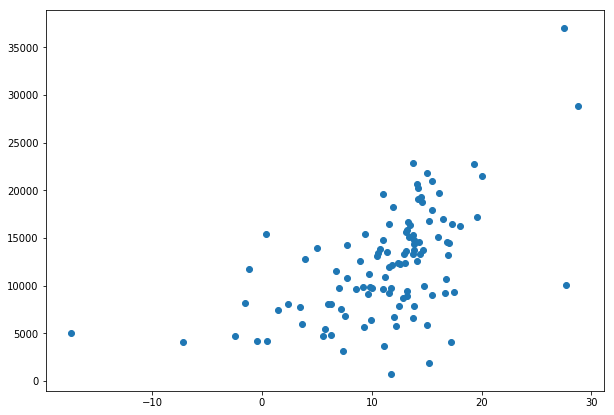

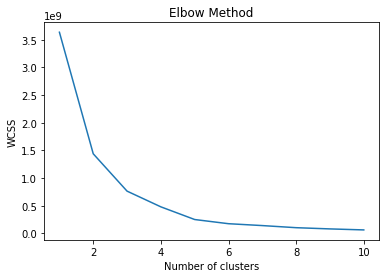

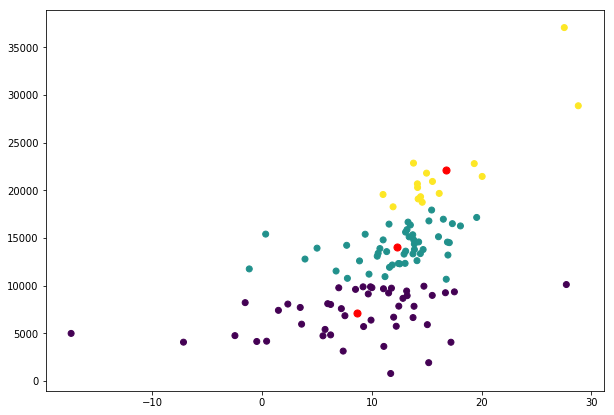

In [254]:
plt.figure(figsize=(10,7))
X = aeroport_full_pays[['TEMPS_RETARD_TOTAL','PRIX_RETARD_TOTAL']].values
plt.scatter(X[:,0], X[:,1])
#plt.scatter(X[:,0], X[:,2],c="DarkGreen")
plt.show()
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
aeroport_full_pays['cluster'] = pred_y
plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1],c=pred_y)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='red')
plt.show()

,TEMPS_RETARD_TOTAL,PRIX_RETARD_TOTAL
cluster,,
0,8.690079,7088.023510
1,12.284294,14069.769212
2,16.714420,22103.161922


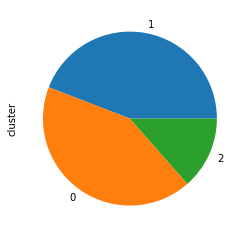

In [343]:
#aeroport_full_pays[['PAYS', 'cluster']]
aeroport_full_pays['cluster'].value_counts().plot.pie()
aeroport_full_pays[['TEMPS_RETARD_TOTAL','PRIX_RETARD_TOTAL', 'cluster']].groupby('cluster').mean().sort_values(by="TEMPS_RETARD_TOTAL")

In [387]:
aeroport_full.columns

Index(['AEROPORT', 'PAYS', 'DEPART_NOM', 'HEURE_DEPART_PROGRAMME',
       'TEMPS_RETARD_DEPART', 'TEMPS_DEPLACEMENT_DECOLLAGE',
       'PRIX_RETARD_DEPART', 'HEURE_ARRIVEE_PROGRAMMEE',
       'TEMPS_RETARD_ARRIVEE', 'TEMPS_DEPLACEMENT_ATTERRISSAGE',
       'PRIX_RETARD_10', 'PRIX_RETARD_APRES', 'PRIX_RETARD_ARRIVEE',
       'TEMPS_RETARD_TOTAL', 'PRIX_RETARD_TOTAL', 'cluster', 'NAME'],
      dtype='object')

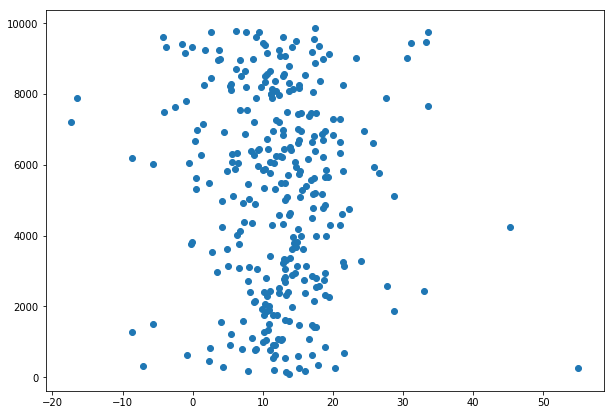

In [388]:
plt.figure(figsize=(10,7))
X = aeroport_full.set_index('AEROPORT')[['TEMPS_RETARD_TOTAL','PRIX_RETARD_10']].values
plt.scatter(X[:,0], X[:,1])

## Cluster par heure 

In [509]:
aeroport_full

,AEROPORT,PAYS,DEPART_NOM,HEURE_DEPART_PROGRAMME,TEMPS_RETARD_DEPART,TEMPS_DEPLACEMENT_DECOLLAGE,PRIX_RETARD_DEPART,HEURE_ARRIVEE_PROGRAMMEE,TEMPS_RETARD_ARRIVEE,TEMPS_DEPLACEMENT_ATTERRISSAGE,PRIX_RETARD_10,PRIX_RETARD_APRES,PRIX_RETARD_ARRIVEE,TEMPS_RETARD_TOTAL,PRIX_RETARD_TOTAL,cluster,NAME
0,AAL,DK,Aalborg Airport,1379.681418,7.189322,17.793955,5166.415919,1432.686522,3.074024,5.723256,8346.0,353.0,5885.003875,10.263346,11051.419794,2,Aalborg Airport(DK)
1,AAP,ID,Aji Pangeran Tumenggung Pranoto International ...,1095.469636,7.395950,17.948951,5311.305866,1724.780339,4.988079,5.644008,9245.0,318.0,6479.122020,12.384028,11790.427886,2,Aji Pangeran Tumenggung Pranoto International ...
2,ABV,NG,Nnamdi Azikiwe International Airport,1144.856947,11.500399,13.046772,5562.555911,1583.765920,9.498813,5.089779,6338.0,272.0,5741.827136,20.999213,11304.383047,2,Nnamdi Azikiwe International Airport(NG)
3,ACC,GH,Kotoka International Airport,419.315094,3.550669,12.273423,8237.179732,285.523132,10.603604,4.365766,2880.0,955.0,12449.990991,14.154273,20687.170723,0,Kotoka International Airport(GH)
4,ADB,TR,Adnan Menderes International Airport,1092.162313,7.514395,16.398077,6878.211132,1920.741245,7.080483,4.771084,2955.0,603.0,6888.513078,14.594878,13766.724211,2,Adnan Menderes International Airport(TR)
5,ADD,ET,Addis Ababa Bole International Airport,1107.650099,5.924324,14.396622,1429.670270,1531.577361,1.475962,5.108532,4386.0,42.0,1713.601648,7.400286,3143.271919,1,Addis Ababa Bole International Airport(ET)
6,AER,RU,Sochi International Airport,1302.810442,5.621615,16.206771,9787.172135,1581.553558,2.768391,3.586341,6377.0,896.0,8474.163244,8.390006,18261.335380,0,Sochi International Airport(RU)
7,AGP,ES,MÃ¡laga Airport,1466.716179,8.901595,17.602910,1408.867203,1427.528370,2.171198,8.698863,771.0,143.0,1473.956017,11.072792,2882.823220,1,MÃ¡laga Airport(ES)
8,AKT,GB,RAF Akrotiri,1535.542857,-0.029268,7.133333,2261.536585,1473.982786,0.615756,4.036918,6973.0,56.0,2551.302251,0.586487,4812.838836,1,RAF Akrotiri(GB)
9,ALA,KZ,Almaty Airport,1184.741369,6.580132,13.507777,3638.083709,1651.242056,4.883752,4.770867,534.0,419.0,4067.426568,11.463884,7705.510277,1,Almaty Airport(KZ)


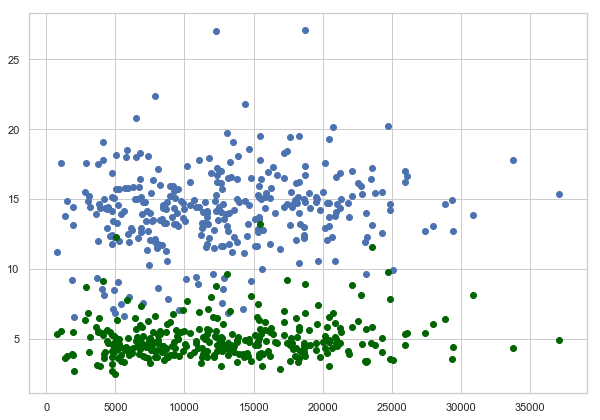

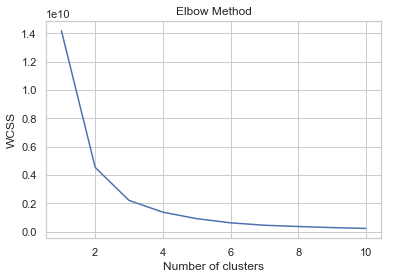

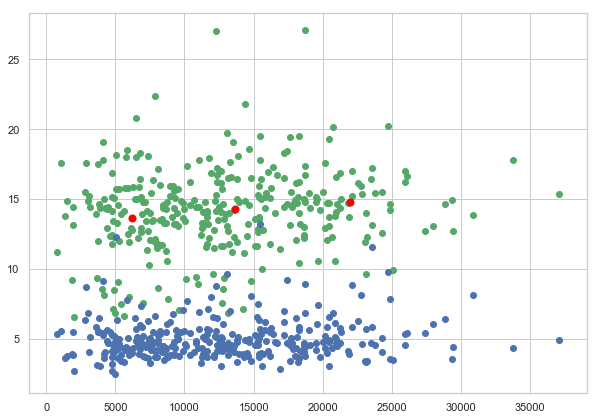

In [510]:
plt.figure(figsize=(10,7))
X = aeroport_full.set_index('AEROPORT')[['PRIX_RETARD_TOTAL','TEMPS_DEPLACEMENT_DECOLLAGE', 'TEMPS_DEPLACEMENT_ATTERRISSAGE']].values
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[:,0], X[:,2],c="DarkGreen")
plt.show()
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1],c='g')
plt.scatter(X[:,0], X[:,2])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='red')
plt.show()